# 0 环境配置

In [40]:
import os
import sys
import timeit
import random
import statistics
from statistics import mean, median
from importlib import reload

In [3]:
base_path = os.path.abspath('')
sys.path.append(base_path)

In [160]:
import oddt
import nglview as nv
import numpy as np
import pandas as pd
from openbabel import openbabel
from icecream import ic
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolAlign
from rdkit.Chem.MolStandardize import rdMolStandardize

In [100]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [121]:
%matplotlib inline
plt.style.use('ggplot')
# plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

In [96]:
import utils.functions as f
import utils.alignment as a
import utils.similarity as s
import utils.metrics as m

In [6]:
from rdkit import RDLogger                                                                                                                                                               
RDLogger.EnableLog('rdApp.*') 

In [205]:
reload(f)
reload(a)
reload(s)
reload(m)

<module 'utils.metrics' from '/home/jovyan/work-home/molecule-3d-similarity/utils/metrics.py'>

In [7]:
random.seed = 2022

# 1 测试

In [ ]:
# 1 Mol2MolSupplier
database=f.Mol2MolSupplier(os.path.join(base_path, 'demo-data/pde5a/actives_final.mol2'), sanitize=True)
len(database)

# 2 PDE5A

In [8]:
decoys_path = os.path.join(base_path, 'demo-data/pde5a/decoys_final.mol2')
actives_path = os.path.join(base_path, 'demo-data/pde5a/actives_final.mol2')
target_rec = os.path.join(base_path, 'demo-data/pde5a/receptor_FH.pdb')
target_lig = os.path.join(base_path, 'demo-data/pde5a/crystal_ligand.mol2')

In [17]:
decoys = f.Mol2MolSupplier(decoys_path, sanitize=True)
len(decoys)

27824

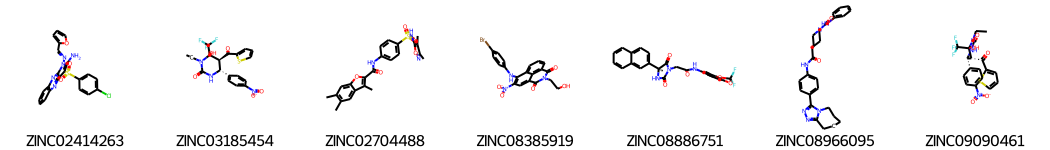

In [18]:
Draw.MolsToGridImage(decoys[:7], molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in decoys[:7]],maxMols=100)

In [19]:
actives=f.Mol2MolSupplier(actives_path, sanitize=True, )
len(actives)

706

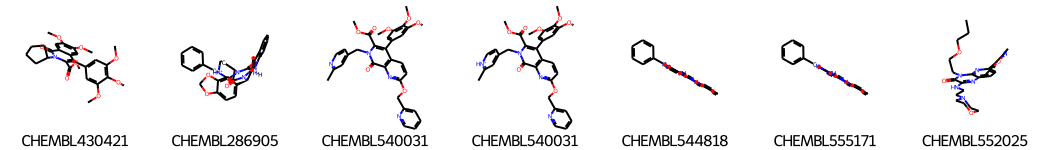

In [20]:
Draw.MolsToGridImage(actives[:7], molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in actives[:7]],maxMols=100)

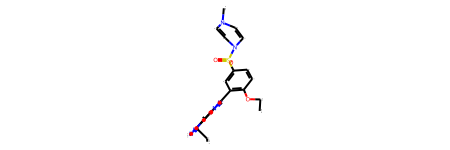

In [21]:
ligand = AllChem.MolFromMol2File(target_lig)
ligand

In [22]:
# ligand = AllChem.MolFromMol2File(os.path.join(base_path, 'demo-data/gcr_crystal_ligand.mol2'), removeHs=False)
# ligand

In [23]:
# ligand = AllChem.MolFromMol2File(os.path.join(base_path, 'demo-data/akt1_crystal_ligand.mol2'), removeHs=False)
# ligand

In [24]:
# ligand = AllChem.MolFromMol2File(os.path.join(base_path, 'demo-data/aa2ar_crystal_ligand.mol2'), sanitize=True, removeHs=False)

In [44]:
# type(ligand)

## 2.1 RDKIT

### 2.1.1 测试分子对齐

In [45]:
actives_o3a_score = a.rdkit_o3a(actives[:10], ligand)
statistics.mean(actives_o3a_score)

101.41567432335957

In [46]:
view = f.show_ligands([ligand]+actives[:10])
view

NGLWidget()

In [47]:
actives_crippeno3a_score = a.rdkit_crippeno3a(actives[:10], ligand)
statistics.mean(actives_crippeno3a_score)

80.00537039377457

In [48]:
view = f.show_ligands([ligand]+actives[:10])
view

NGLWidget()

In [49]:
# rmsd = rdkit_alignmol(actives[:10], ligand)
# statistics.mean(rmsd)
# # RuntimeError: No sub-structure match found between the probe and query mol

In [50]:
decoys_o3a_score = a.rdkit_o3a(decoys[:10], ligand)
statistics.mean(decoys_o3a_score)

109.99845411934537

In [51]:
view = f.show_ligands([ligand]+decoys[:10])
view

NGLWidget()

In [52]:
decoys_crippeno3a_score = a.rdkit_crippeno3a(decoys[:10], ligand)
statistics.mean(decoys_crippeno3a_score)

78.36564200652191

In [53]:
view = f.show_ligands([ligand]+decoys[:10])
view

NGLWidget()

In [28]:
prb_crippen = [Chem.rdMolDescriptors._CalcCrippenContribs(mol) for mol in actives[:10]]
ref_crippen = Chem.rdMolDescriptors._CalcCrippenContribs(ligand)

In [29]:
actives_crippeno3a_score = a.rdkit_crippeno3a(actives[:10], ligand, prb_crippen=prb_crippen, ref_crippen=ref_crippen)
statistics.mean(actives_crippeno3a_score)

80.005370393773

In [30]:
# prb_mmff = [AllChem.MMFFGetMoleculeProperties(mol) for mol in actives[0:10]]
# ref_mmff = AllChem.MMFFGetMoleculeProperties(ligand)
# decoys_o3a_score = rdkit_o3a(decoys[:10], ligand, prb_mmff=prb_mmff, ref_mmff=ref_mmff)
# statistics.mean(decoys_o3a_score)
# # RuntimeError: Invariant Violation
# # 	Negative weight specified for a point
# # 	Violation occurred on line 57 in file Code/Numerics/Alignment/AlignPoints.cpp
# # 	Failed Expression: wData[i] > 0.0
# # 	RDKIT: 2022.03.4
# # 	BOOST: 1_74

### 2.1.2 分子三维结构相似度计算

In [29]:
actives_crippeno3a_score = a.rdkit_crippeno3a(actives[:10], ligand)
ic(mean(actives_crippeno3a_score))
protrude_list = s.rdkit_shape_protrude_dist(actives[:10], ligand)
ic(mean(protrude_list))

ic| mean(actives_crippeno3a_score): 80.00537039377352
ic| mean(protrude_list): 0.5375994750814261


0.5375994750814261

In [30]:
actives_crippeno3a_score = a.rdkit_crippeno3a(actives[:10], ligand)
ic(mean(actives_crippeno3a_score))
protrude_list = s.rdkit_shape_protrude_dist(actives[:10], ligand, allowReordering=True)
ic(mean(protrude_list))

ic| mean(actives_crippeno3a_score): 80.0053703937738
ic| mean(protrude_list): 0.5678650079562517


0.5678650079562517

In [31]:
decoys_crippeno3a_score = a.rdkit_crippeno3a(decoys[:10], ligand)
ic(mean(decoys_crippeno3a_score))
dist_list = s.rdkit_shape_protrude_dist(decoys[:10], ligand)
ic(mean(dist_list))

ic| mean(decoys_crippeno3a_score): 78.36564200652202
ic| mean(dist_list): 0.5298084988631767


0.5298084988631767

In [32]:
decoys_crippeno3a_score = a.rdkit_crippeno3a(decoys[:10], ligand)
ic(mean(decoys_crippeno3a_score))
dist_list = s.rdkit_shape_protrude_dist(decoys[:10], ligand, allowReordering=True)
ic(mean(dist_list))

ic| mean(decoys_crippeno3a_score): 78.36564200652116
ic| mean(dist_list): 0.5298084988631767


0.5298084988631767

In [208]:
def toy_test_similarity(s_func, prb_mols, ref_mol, align_func=None):
    start = timeit.default_timer()
    if align_func:
        align_score =align_func(prb_mols, ref_mol)   
        # ic(mean(align_score))
    similarity_list = s_func(prb_mols, ref_mol)
    end = timeit.default_timer()

    ic(mean(similarity_list))
    ic(median(similarity_list))
    time = (end - start) / len(prb_mols) * 100
    # ic(f'time(100items/s): {time}')
    return similarity_list, time

In [25]:
# actives_sampled = random.sample(actives, 100)
# decoys_sampled = random.sample(decoys, 500)
# RDLogger.DisableLog('rdApp.*') 

In [77]:
actives_sampled_path = os.path.join(base_path, 'demo-data/pde5a/actives_sample_100.sdf')
decoys_sampled_path = os.path.join(base_path, 'demo-data/pde5a/decoys_sample_500.sdf')


In [27]:
# writer = Chem.SDWriter(actives_sampled_path)
# for cid in range(len(actives_sampled)):
#     writer.write(actives_sampled[cid])
    
# writer = Chem.SDWriter(decoys_sampled_path)
# for cid in range(len(decoys_sampled)):
#     writer.write(decoys_sampled[cid])

In [206]:
actives_sampled = [m for m in Chem.SDMolSupplier(actives_sampled_path) if m]
decoys_sampled = [m for m in Chem.SDMolSupplier(decoys_sampled_path) if m]
ligand = AllChem.MolFromMol2File(target_lig)

In [58]:
len(decoys_sampled)

500

In [209]:
# similarity_methods = {
#     'rdkit_protrude': s.rdkit_shape_protrude_dist, 
#     'rdkit_tanimoto': s.rdkit_shape_tanimoto_dist,
#     'rdkit_tversky': s.rdkit_shape_tversky_index,
#     'rdkit_sc': s.rdkit_sc_score,
#     'rdkit_sc_puls': s.rdkit_sc_score_plus,
#     'rdkit_pharm_tanimoto': s.rdkit_pharm_tanimoto,
#     'rdkit_pharm_tversky': s.rdkit_pharm_tversky,
# }

similarity_methods = {
    'rdkit_sc_tversky': s.rdkit_sc_score_tversky,
}
do_not_align = ['rdkit_pharm_tanimoto', 'rdkit_pharm_tversky']

align_funcs_map = {
    'o3a': a.rdkit_o3a, 
    'crippeno3a': a.rdkit_crippeno3a
}
align_funcs_list = ['o3a', 'crippeno3a']

sim_dict = dict()

for name, func in similarity_methods.items():
    ic(f'🌟 {name} 🌟')
    actives_sim_list = []
    decoys_sim_list = []
    ic('----👇 actives 👇----')
    align_funcs = align_funcs_list if name not in do_not_align else [None]
    tmp_time_list = []
    for align_name in align_funcs:
        if align_name:
            result_name = f'{name}-{align_name}'
            align_func = align_funcs_map[align_name]
        else:
            result_name = name
        tmp_sim, time = toy_test_similarity(
                            func, 
                            actives_sampled, 
                            ligand, 
                            align_func=align_func
                            )
        result_tmp = sim_dict.get(result_name, [])
        # result_tmp['score'] = result_tmp.get('score', []) + tmp_sim
        # result_tmp['label'] = result_tmp.get('label', []) + (len(tmp_sim) * [1])
        result_tmp += [(ele, 1) for ele in tmp_sim]
        sim_dict[result_name] = result_tmp
        tmp_time_list.append(time)

    ic('----👇 decoys 👇----')
    for align_name in align_funcs:
        if align_name:
            result_name = f'{name}-{align_name}'
            align_func = align_funcs_map[align_name]
        else:
            result_name = name
        tmp_sim, time = toy_test_similarity(
                        func, 
                        decoys_sampled, 
                        ligand, 
                        align_func=align_func
                        )
        result_tmp = sim_dict.get(result_name, [])
        result_tmp += [(ele, 0) for ele in tmp_sim]
        assert len(result_tmp) == 600, f"len(result_tmp) = {len(result_tmp)}"
        sim_dict[result_name] = result_tmp
        tmp_time_list.append(time)
    
    for i in range(len(tmp_time_list)//2):
        ic(mean(tmp_time_list[i::len(tmp_time_list)//2]))

ic| f'🌟 {name} 🌟': '🌟 rdkit_sc_tversky 🌟'
ic| '----👇 actives 👇----'
ic| mean(similarity_list): 0.38241305148491594
ic| median(similarity_list): 0.3429992553073429
ic| mean(similarity_list): 0.3778965592295994
ic| median(similarity_list): 0.34176072418751735
ic| '----👇 decoys 👇----'
ic| mean(similarity_list): 0.31590123156213146
ic| median(similarity_list): 0.30648471028669233
ic| mean(similarity_list): 0.3066459643751121
ic| median(similarity_list): 0.29888899567994953
ic| mean(tmp_time_list[i::len(tmp_time_list)//2]): 4.233352020732127
ic| mean(tmp_time_list[i::len(tmp_time_list)//2]): 2.9093949170550335


In [87]:
for name, score_list in sim_dict.items():
    mean_actives_score = mean([ele[0] for ele in score_list if ele[1]==1])
    mean_decoys_score = mean([ele[0] for ele in score_list if ele[1]==0])
    ic(name)
    ic(mean_actives_score)
    ic(mean_decoys_score)

ic| name: 'rdkit_pharm_tanimoto'
ic| mean_actives_score: 0.16776801522549217
ic| mean_decoys_score: 0.11318089636545936
ic| name: 'rdkit_pharm_tversky'
ic| mean_actives_score: 0.30567672423624714
ic| mean_decoys_score: 0.19477565448111214
ic| name: 'rdkit_sc_puls-o3a'
ic| mean_actives_score: 0.2971149195496682
ic| mean_decoys_score: 0.22848753784638984
ic| name: 'rdkit_sc_puls-crippeno3a'
ic| mean_actives_score: 0.2921506900369559
ic| mean_decoys_score: 0.21841189084810675
ic| name: 'rdkit_sc-o3a'
ic| mean_actives_score: 0.38822184364626605
ic| mean_decoys_score: 0.3266942380340095
ic| name: 'rdkit_sc-crippeno3a'
ic| mean_actives_score: 0.38384024494413677
ic| mean_decoys_score: 0.3174712700125297
ic| name: 'rdkit_protrude-o3a'
ic| mean_actives_score: 0.5240270280317699
ic| mean_decoys_score: 0.5258186142536612
ic| name: 'rdkit_protrude-crippeno3a'
ic| mean_actives_score: 0.5342978117466739
ic| mean_decoys_score: 0.5371715495198699
ic| name: 'rdkit_tanimoto-o3a'
ic| mean_actives_score:

## 2.2 ODDT

### 2.2.1 测试

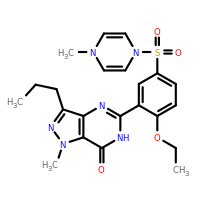

In [89]:
next(oddt.toolkit.readfile('mol2', target_lig))

In [90]:
tmp = [mol for mol in list(oddt.toolkit.readfile('sdf', decoys_sampled_path)) if mol]
len(tmp)

32

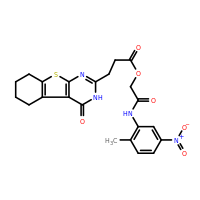

In [91]:
tmp[0]

### 2.2.2 相似度计算

In [74]:
ligand = next(oddt.toolkit.readfile('mol2', target_lig))
actives_sampled = [mol for mol in oddt.toolkit.readfile('sdf', actives_sampled_path) if mol]
decoys_sampled = [mol for mol in oddt.toolkit.readfile('sdf', decoys_sampled_path) if mol]


In [75]:
def toy_test_similarity(s_func, prb_mols, ref_mol):
    start = timeit.default_timer()
    score_list = s_func(prb_mols, ref_mol)
    end = timeit.default_timer()
    
    ic(mean(score_list))
    ic(median(score_list))

    return score_list, (end - start)/len(prb_mols)*100


In [85]:
similarity_methods = {
    'oddt_usr': s.oddt_usr,
    'oddt_usr_cat': s.oddt_usr_cat,
    'oddt_electroshape': s.oddt_electroshape,
}
for name, func in similarity_methods.items():
    ic(f'🌟 {name} 🌟')
    result_tmp = sim_dict.get(name, [])
    ic('----👇 actives 👇----')
    similarity_score, time_a = toy_test_similarity(func, actives_sampled, ligand)
    result_tmp += [(ele, 1) for ele in similarity_score]
    ic('----👇 decoys 👇----')
    similarity_score, time_d = toy_test_similarity(func, decoys_sampled, ligand)
    result_tmp += [(ele, 0) for ele in similarity_score]
    assert len(result_tmp) == 600, f"len(result_tmp) = {len(result_tmp)}"
    sim_dict[name] = result_tmp
    ic(mean([time_a, time_d]))

ic| f'🌟 {name} 🌟': '🌟 oddt_usr 🌟'
ic| '----👇 actives 👇----'
ic| mean(score_list): 0.24046535513381426
ic| median(score_list): 0.23170247364625657
ic| '----👇 decoys 👇----'
ic| mean(score_list): 0.2098999849586954
ic| median(score_list): 0.20468122767571073
ic| mean([time_a, time_d]): 0.042741477373056114
ic| f'🌟 {name} 🌟': '🌟 oddt_usr_cat 🌟'
ic| '----👇 actives 👇----'
ic| mean(score_list): 0.16980020757321382
ic| median(score_list): 0.17139906371863223
ic| '----👇 decoys 👇----'
ic| mean(score_list): 0.15483883127733994
ic| median(score_list): 0.16161127532038075
ic| mean([time_a, time_d]): 0.1884836256271228
ic| f'🌟 {name} 🌟': '🌟 oddt_electroshape 🌟'
ic| '----👇 actives 👇----'
ic| mean(score_list): 0.48695157708706704
ic| median(score_list): 0.5301534039108563
ic| '----👇 decoys 👇----'
ic| mean(score_list): 0.4634083253647392
ic| median(score_list): 0.45820326834765995
ic| mean([time_a, time_d]): 0.04586341045796871


In [86]:
sim_dict.keys()

dict_keys(['rdkit_pharm_tanimoto', 'rdkit_pharm_tversky', 'rdkit_sc_puls-o3a', 'rdkit_sc_puls-crippeno3a', 'rdkit_sc-o3a', 'rdkit_sc-crippeno3a', 'rdkit_protrude-o3a', 'rdkit_protrude-crippeno3a', 'rdkit_tanimoto-o3a', 'rdkit_tanimoto-crippeno3a', 'rdkit_tversky-o3a', 'rdkit_tversky-crippeno3a', 'oddt_usr', 'oddt_usr_cat', 'oddt_electroshape'])

In [83]:
sim_dict.pop('oddt_usr')

[(0.28914666061374356, 1),
 (0.31908019615106, 1),
 (0.271505990759749, 1),
 (0.22918407111640754, 1),
 (0.20505716532747062, 1),
 (0.31283751401696575, 1),
 (0.1623952972465158, 1),
 (0.30193887191755014, 1),
 (0.14787295807665343, 1),
 (0.45102894020860296, 1),
 (0.3885416706792657, 1),
 (0.27014988933217654, 1),
 (0.28072759138725134, 1),
 (0.029382086402024356, 1),
 (0.2651363528719721, 1),
 (0.24555231151321116, 1),
 (0.191364803686189, 1),
 (0.17695805678288856, 1),
 (0.4478866925238533, 1),
 (0.4369629602596666, 1),
 (0.36824861279219717, 1),
 (0.294195590856682, 1),
 (0.22017844639262613, 1),
 (0.415831641799737, 1),
 (0.2236895410471398, 1),
 (0.38295075046817917, 1),
 (0.22316749500868702, 1),
 (0.17658292120287913, 1),
 (0.19982654458599544, 1),
 (0.2702010057082071, 1),
 (0.17944594883442347, 1),
 (0.28011608789877745, 1),
 (0.2817247918981004, 1),
 (0.17959672957802414, 1),
 (0.25863671390337756, 1),
 (0.26326801163477576, 1),
 (0.16758005062893533, 1),
 (0.323057994704806

## 2.3 评价指标

In [166]:
test_list = sorted(sim_dict['oddt_usr'], key=lambda x: x[0])

y_lable = np.asarray([ele[1] for ele in test_list])
y_score = np.asarray([ele[0] for ele in test_list])

In [167]:
fpr, tpr, _ = metrics.roc_curve(y_lable, y_score)
roc_auc = metrics.auc(fpr, tpr)

In [168]:
fpr

array([0.   , 0.002, 0.004, 0.004, 0.008, 0.008, 0.01 , 0.01 , 0.022,
       0.022, 0.024, 0.024, 0.03 , 0.03 , 0.034, 0.034, 0.048, 0.048,
       0.05 , 0.05 , 0.062, 0.062, 0.074, 0.074, 0.076, 0.076, 0.084,
       0.084, 0.086, 0.086, 0.102, 0.102, 0.122, 0.122, 0.124, 0.124,
       0.136, 0.136, 0.142, 0.142, 0.146, 0.146, 0.15 , 0.15 , 0.154,
       0.154, 0.168, 0.168, 0.176, 0.176, 0.18 , 0.18 , 0.184, 0.184,
       0.186, 0.186, 0.2  , 0.2  , 0.202, 0.202, 0.216, 0.216, 0.23 ,
       0.23 , 0.234, 0.234, 0.238, 0.238, 0.24 , 0.24 , 0.254, 0.254,
       0.28 , 0.28 , 0.286, 0.286, 0.298, 0.298, 0.316, 0.316, 0.334,
       0.334, 0.344, 0.344, 0.346, 0.346, 0.348, 0.348, 0.362, 0.362,
       0.366, 0.366, 0.378, 0.378, 0.392, 0.392, 0.394, 0.394, 0.398,
       0.398, 0.406, 0.406, 0.408, 0.408, 0.426, 0.426, 0.452, 0.452,
       0.456, 0.456, 0.466, 0.466, 0.486, 0.486, 0.494, 0.494, 0.552,
       0.552, 0.56 , 0.56 , 0.566, 0.566, 0.596, 0.596, 0.602, 0.602,
       0.638, 0.638,

In [169]:
tpr

array([0.  , 0.  , 0.  , 0.02, 0.02, 0.03, 0.03, 0.05, 0.05, 0.06, 0.06,
       0.07, 0.07, 0.08, 0.08, 0.09, 0.09, 0.1 , 0.1 , 0.11, 0.11, 0.13,
       0.13, 0.14, 0.14, 0.15, 0.15, 0.16, 0.16, 0.17, 0.17, 0.18, 0.18,
       0.19, 0.19, 0.2 , 0.2 , 0.21, 0.21, 0.22, 0.22, 0.23, 0.23, 0.24,
       0.24, 0.25, 0.25, 0.26, 0.26, 0.28, 0.28, 0.29, 0.29, 0.3 , 0.3 ,
       0.32, 0.32, 0.34, 0.34, 0.35, 0.35, 0.36, 0.36, 0.38, 0.38, 0.39,
       0.39, 0.4 , 0.4 , 0.41, 0.41, 0.42, 0.42, 0.44, 0.44, 0.45, 0.45,
       0.46, 0.46, 0.47, 0.47, 0.48, 0.48, 0.49, 0.49, 0.5 , 0.5 , 0.52,
       0.52, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.57, 0.57, 0.58, 0.58,
       0.59, 0.59, 0.6 , 0.6 , 0.61, 0.61, 0.62, 0.62, 0.64, 0.64, 0.65,
       0.65, 0.66, 0.66, 0.67, 0.67, 0.68, 0.68, 0.7 , 0.7 , 0.71, 0.71,
       0.72, 0.72, 0.73, 0.73, 0.74, 0.74, 0.75, 0.75, 0.76, 0.76, 0.78,
       0.78, 0.79, 0.79, 0.81, 0.81, 0.82, 0.82, 0.84, 0.84, 0.85, 0.85,
       0.87, 0.87, 0.88, 0.88, 0.89, 0.89, 0.9 , 0.

In [ ]:
plt.figure(figsize=(5, 5), dpi=200)
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")

plt.show()

In [171]:
m.roc_log_auc(y_true=y_lable, y_score=y_score)

0.10086364425579848

In [172]:
m.roc_log_auc(y_true=y_lable, y_score=y_score) - 0.1446

-0.043736355744201524

In [189]:
m.enrichment_factor(y_true=y_lable, y_score=y_score, percentage=0.5)

2.0

In [190]:
m.enrichment_factor(y_true=y_lable, y_score=y_score, percentage=2)

0.5

In [191]:
m.enrichment_factor(y_true=y_lable, y_score=y_score, percentage=8)

0.5

In [180]:
m.bedroc(y_true=y_lable, y_score=y_score, alpha=321)

0.41500601842788387

In [176]:
m.bedroc(y_true=y_lable, y_score=y_score, alpha=80.5)

0.15752307135780552

In [178]:
m.bedroc(y_true=y_lable, y_score=y_score, alpha=20.0)

0.10049539298375539

In [194]:
m.early_enrichment(fpr=fpr, tpr=tpr)

3.0

In [161]:
df = pd.read_csv('pde5_score.csv')

In [182]:
df_sorted = df.sort_values(by=['score'],ascending=True)

In [183]:
score = df_sorted['score']
x = np.array(score)*(-1)

In [184]:
y = df_sorted['label']
label_map = {'active': 1, 'decoy': 0}
labels = [label_map[y_true] for y_true in y]
y = np.array(labels)

In [185]:
ic(m.bedroc(y_true=y, y_score=x, alpha=20.0))
ic(m.bedroc(y_true=y, y_score=x, alpha=80.5))
ic(m.bedroc(y_true=y, y_score=x, alpha=321))

ic| m.bedroc(y_true=y, y_score=x, alpha=20.0): 0.4518017076489426
ic| m.bedroc(y_true=y, y_score=x, alpha=80.5): 0.4851564477861724
ic| m.bedroc(y_true=y, y_score=x, alpha=321): 0.712265314462101


0.712265314462101

In [188]:
ic(m.enrichment_factor(y_true=y, y_score=x, percentage=8))
ic(m.enrichment_factor(y_true=y, y_score=x, percentage=2))
ic(m.enrichment_factor(y_true=y, y_score=x, percentage=0.5))

ic| m.enrichment_factor(y_true=y, y_score=x, percentage=8): 5.243784307394252
ic| m.enrichment_factor(y_true=y, y_score=x, percentage=2): 13.029525032092426
ic| m.enrichment_factor(y_true=y, y_score=x, percentage=0.5): 14.56937799043062


14.56937799043062

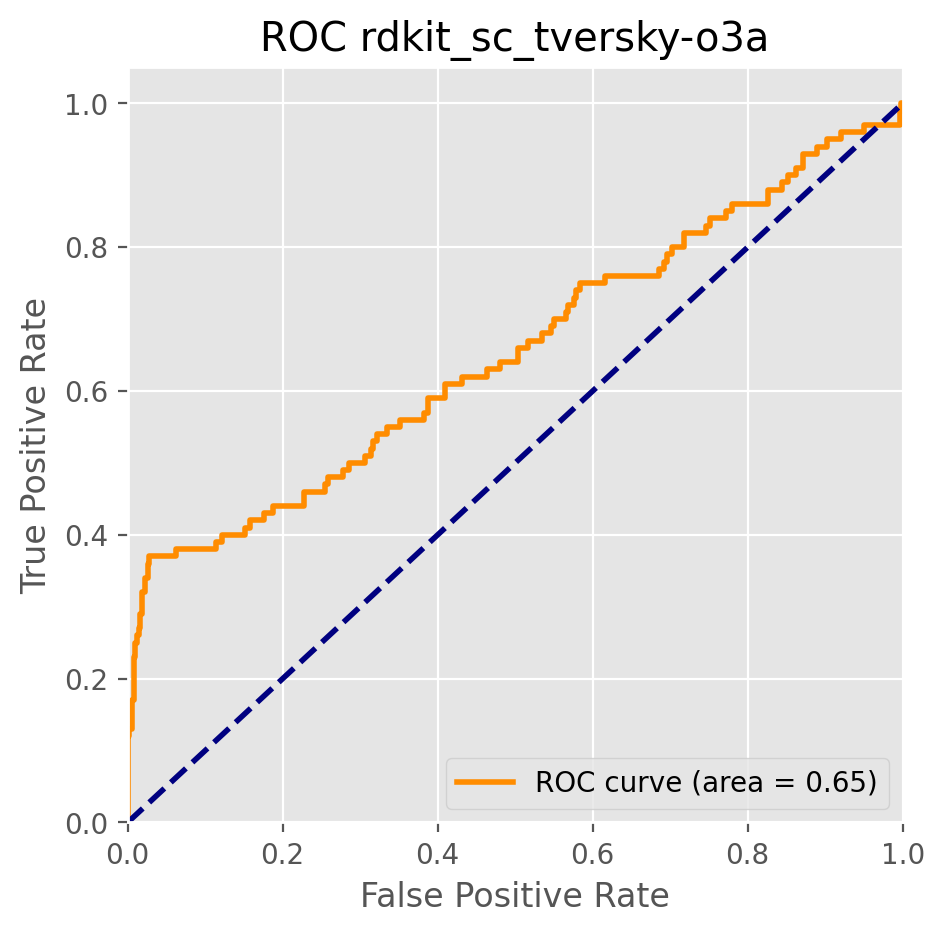

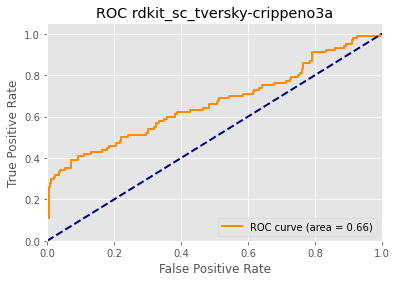

In [210]:
plt.figure(figsize=(5, 5), dpi=200)
for name, score in sim_dict.items():
    
    score_list = sorted(score, key=lambda x: x[0])

    y_lable = np.asarray([ele[1] for ele in score_list])
    y_score = np.asarray([ele[0] for ele in score_list])

    fpr, tpr, _ = metrics.roc_curve(y_lable, y_score)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC {name}")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(base_path, f'demo-data/result/{name}.png'))
    plt.show()

In [211]:
result_list = []
for name, score in sim_dict.items():
    score_list = sorted(score, key=lambda x: x[0])

    y_score = np.asarray([ele[0] for ele in score_list])
    y_lable = np.asarray([ele[1] for ele in score_list])
    
    metrics_list = m.calculate_metrics(y_lable=y_lable, y_score=y_score)

    print(f'--- 🌟 {name} 🌟 ---')
    tmp_dict = {
        'name' : name,
    }
    for m_name, m_value in metrics_list.items():
        tmp_dict[m_name] = m_value
        print(f'{m_name:<30}: {m_value}')
    result_list.append(tmp_dict)

--- 🌟 rdkit_sc_tversky-o3a 🌟 ---
auc                           : 0.65358
log_acu                       : 0.1060734480045468
adjusted_log_auc              : -0.03852655199545321
EF^0.5%                       : 2.0
EF^2%                         : 1.5
EF^8%                         : 0.6250000000000001
BEDROC(alpha=20.0)            : 0.14222512499290904
BEDROC(alpha=80.5)            : 0.270580071819024
BEDROC(alpha=321.9)           : 0.3744061576906402
ER_1%                         : 23.0
--- 🌟 rdkit_sc_tversky-crippeno3a 🌟 ---
auc                           : 0.6641999999999999
log_acu                       : 0.0919678346848579
adjusted_log_auc              : -0.0526321653151421
EF^0.5%                       : 0.0
EF^2%                         : 0.5
EF^8%                         : 0.375
BEDROC(alpha=20.0)            : 0.08133862624867438
BEDROC(alpha=80.5)            : 0.08547209233674254
BEDROC(alpha=321.9)           : 0.08303655594978569
ER_1%                         : 28.000000000000004

In [204]:
pd.DataFrame(result_list).to_excel(os.path.join(base_path, 'demo-data/result/toy_metrics_sc_tversky.xlsx'))